In [9]:
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten, GlobalAveragePooling2D, LeakyReLU, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras import Model
import pandas as pd
import numpy as np
from sklearn import metrics
import cv2
from matplotlib import pyplot as plt
import tqdm

In [10]:
Random_Dimension = 160

(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
xtrain = (xtrain.astype(np.float32) - 127.5)/127.5
xtrain = xtrain.reshape(60000, 784)

In [11]:
adam = Adam(lr = 0.0002, beta_1 = 0.5) 

generator = Sequential()
generator.add(Dense(256, input_dim=Random_Dimension, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss = 'binary_crossentropy', optimizer=adam)

descriminator = Sequential()
descriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Dropout(0.3))
descriminator.add(Dense(512))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Dropout(0.3))
descriminator.add(Dense(256))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Dropout(0.3))
descriminator.add(Dense(1, activation='sigmoid'))
descriminator.compile(loss = 'binary_crossentropy', optimizer=adam)

descriminator.trainable = False
GAN_Input = Input(shape=(Random_Dimension,))
I = generator(GAN_Input)
GAN_Output = descriminator(I)
GAN = Model(inputs = GAN_Input, outputs = GAN_Output)
GAN.compile(loss = 'binary_crossentropy', optimizer=adam)

In [12]:
generator_Losses = []
descriminator_Losses = []

def Plot_Loss(epochs):
  plt.figure(figsize = (15, 9))
  plt.plot(descriminator_Losses, label='Discriminitive Loss')
  plt.plot(generator_Losses, label='Generative Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  


In [13]:
def Generated_Images(epochs, examples=100, dim=(10,10), figsize=(10,10)):
  GAN_noise = np.random.normal(0, 1, size=[examples, Random_Dimension])
  Generated = generator.predict(GAN_noise)
  Generated = Generated.reshape(examples, 28, 28)
  print(Generated.shape)
  plt.figure(figsize=figsize)
  for i in range(Generated.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(Generated[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
  plt.tight_layout()

Epochs: 10
Batch Size: 150
Batch Per Epoch: 400.0
----- epoch 1 

(100, 28, 28)
----- epoch 2 

----- epoch 3 

----- epoch 4 

----- epoch 5 

----- epoch 6 

----- epoch 7 

----- epoch 8 

----- epoch 9 

----- epoch 10 

(100, 28, 28)


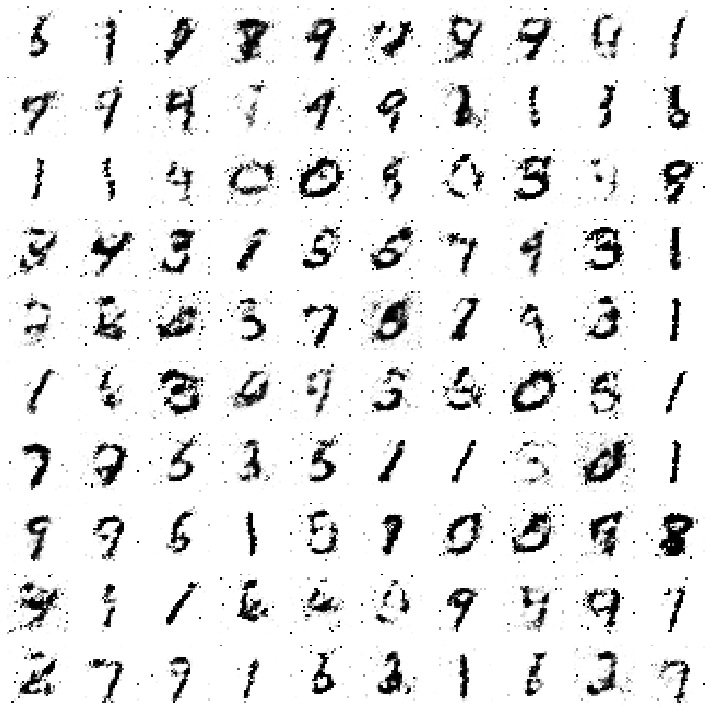

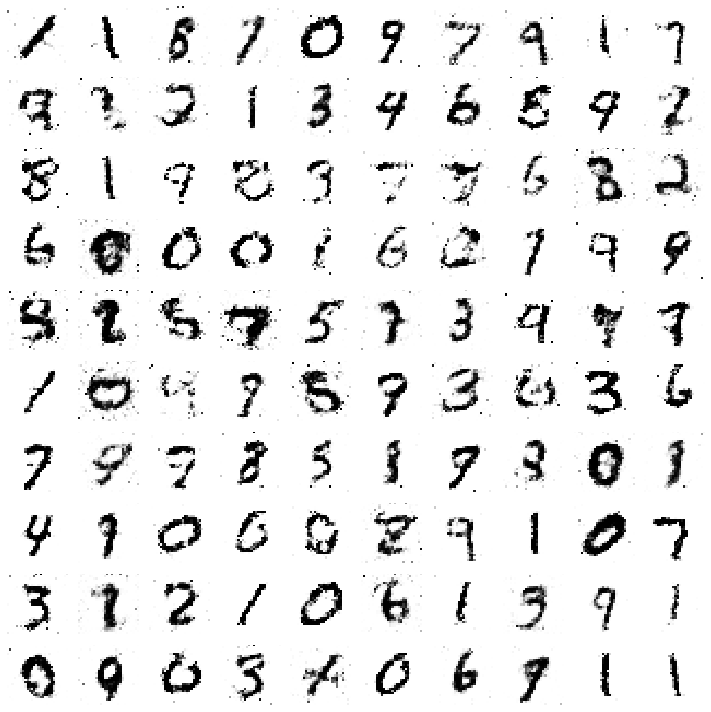

In [17]:
def ganTrain(epochs=1, batch_size = 128):
  batch_count = xtrain.shape[0]/batch_size
  print('Epochs:', epochs)
  print('Batch Size:', batch_size)
  print('Batch Per Epoch:', batch_count)

  for e in range(1, epochs+1):
    print('-'*5, 'epoch %d' %e,'\n'  )
    for i in range(int(batch_count)):
      GAN_noise = np.random.normal(0, 1, size=[batch_size, Random_Dimension])
      batch_image = xtrain[np.random.randint(0, xtrain.shape[0], size=batch_size)]

      Generated = generator.predict(GAN_noise)
      I = np.concatenate([batch_image, Generated])

      O_Discriminator = np.zeros(2*batch_size)
      O_Discriminator[:batch_size] = 0.9

      descriminator.trainable = True
      descriminator_Losse = descriminator.train_on_batch(I, O_Discriminator)

      GAN_noise = np.random.normal(0, 1, size=[batch_size, Random_Dimension])
      O_Generator = np.ones(batch_size)
      descriminator.trainable = False
      generator_Losse = GAN.train_on_batch(GAN_noise, O_Generator)

    generator_Losses.append(descriminator_Losse)
    descriminator_Losses.append(descriminator_Losse) 

    if e==1 or e==epochs:
      Generated_Images(e)



if __name__ == '__main__':
  ganTrain(10, 150)